In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from matplotlib.animation import FuncAnimation

pd.options.display.max_columns = None

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

In [11]:
# 1. Loading the Financial Dataset
fin_data = pd.read_csv("compustat_2000_clean.csv", na_values = ["NA", "na", "?"], low_memory = False)

In [13]:
fin_data = fin_data.dropna(axis=1)
fin_data.shape

(235996, 301)

In [53]:
# Selecting the two features for visualization
selected_columns = ["capx", "dltt"]

# Slice the DataFrame to include only these columns
X = fin_data[selected_columns]

# Display the first few rows
print(X.head())

X.dtypes

     capx     dltt
0  13.134  179.987
1  12.112  217.699
2   9.930  164.658
3  10.286  248.666
4  13.033  227.159


capx    float64
dltt    float64
dtype: object

In [49]:
# Convert to a pandas DataFrame for easier handling
cluster_data = pd.DataFrame(X, columns=["capx", "dltt"])
y = fin_data['sic']
cluster_data['sic'] = y

In [51]:
print("First five rows of the dataset:")
print(cluster_data.head())

First five rows of the dataset:
     capx     dltt   sic
0  13.134  179.987  5080
1  12.112  217.699  5080
2   9.930  164.658  5080
3  10.286  248.666  5080
4  13.033  227.159  5080


In [65]:
from scipy.stats.mstats import winsorize

#Finds the values for 1st percentile and 99th percentile
capx_lower, capx_upper = np.percentile(cluster_data["capx"].dropna(), [1, 99])
dltt_lower, dltt_upper = np.percentile(cluster_data["dltt"].dropna(), [1, 99])

print(f"Capital Expenditure (capx) Winsorization Limits: {capx_lower} to {capx_upper}")
print(f"Long-Term Debt (dltt) Winsorization Limits: {dltt_lower} to {dltt_upper}")

Capital Expenditure (capx) Winsorization Limits: 0.0 to 3621.3138499999927
Long-Term Debt (dltt) Winsorization Limits: 0.0 to 28359.859699999568


In [67]:
# Apply Winsorization using clip() for exact percentile-based capping
cluster_data["capx_winsorized"] = cluster_data["capx"].clip(lower=0.0, upper=3621.31)
cluster_data["dltt_winsorized"] = cluster_data["dltt"].clip(lower=0.0, upper=28359.86)

# Display summary statistics to verify
print(cluster_data[["capx", "capx_winsorized", "dltt", "dltt_winsorized"]].describe())

                capx  capx_winsorized          dltt  dltt_winsorized
count  235996.000000    235996.000000  2.359960e+05    235996.000000
mean      188.024907       129.670015  1.961889e+03      1023.302956
std      1232.251539       485.490747  3.559719e+04      3730.544236
min     -3258.000000         0.000000 -2.300000e-02         0.000000
25%         0.871000         0.871000  9.670000e-01         0.967000
50%         4.891000         4.891000  2.574800e+01        25.748000
75%        23.471250        23.471250  2.406628e+02       240.662750
max     82999.000000      3621.310000  4.216909e+06     28359.860000


In [55]:
# 2. Defining the K-Means Function
def k_means(X, k, max_iters=100):
    """
    Perform K-Means clustering.

    Parameters:
    - X: Data points, numpy array of shape (n_samples, n_features)
    - k: Number of clusters
    - max_iters: Maximum number of iterations

    Returns:
    - centroids: Final centroids
    - clusters: Cluster assignments for each data point
    - centroids_history: History of centroids for visualization
    """
    # Initialize centroids randomly from the data points
    np.random.seed(42)
    initial_indices = np.random.choice(len(X), k, replace=False)
    centroids = X[initial_indices]

    centroids_history = [centroids.copy()]

    for i in range(max_iters):
        # Assign clusters based on closest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # Shape: (n_samples, k)
        clusters = np.argmin(distances, axis=1)

        # Compute new centroids as the mean of assigned points
        new_centroids = np.array([X[clusters == j].mean(axis=0) if len(X[clusters == j]) > 0 else centroids[j] for j in range(k)])

        # If centroids do not change, break the loop
        if np.allclose(centroids, new_centroids):
            print(f"Converged after {i+1} iterations.")
            break

        centroids = new_centroids
        centroids_history.append(centroids.copy())

    return centroids, clusters, centroids_history

In [69]:
# 3. Running K-Means
X_np = cluster_data[["capx_winsorized", "dltt_winsorized"]].values
k = 3
centroids, clusters, centroids_history = k_means(X_np, k)

print("\nFinal Centroids:")
print(centroids)

Converged after 26 iterations.

Final Centroids:
[[ 2072.99022197 25624.23555757]
 [   51.73685655   274.12724132]
 [ 1126.41393543  8170.0638119 ]]


In [71]:
# 4. Visualizing the K-Means Learning Process

# 4.1. Plotting Centroid Movements
def plot_centroids_history(X, centroids_history, k):
    plt.figure(figsize=(12, 8))
    plt.title('K-Means Centroid Movements')
    plt.xlabel('Capital Expenditure Winsorized')
    plt.ylabel('Long-Term Debt Winsorized')

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], s=30, c='gray', alpha=0.5, label='Data Points')

    # Colors for centroids
    centroid_colors = ['r', 'g', 'b']

    for i, centroids in enumerate(centroids_history):
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    s=200,
                    c=centroid_colors,
                    marker='X',
                    edgecolor='k',
                    label='Centroids' if i == 0 else "")
        if i > 0:
            # Draw lines from previous centroids to current
            previous_centroids = centroids_history[i - 1]
            for j in range(k):
                plt.plot([previous_centroids[j, 0], centroids[j, 0]],
                         [previous_centroids[j, 1], centroids[j, 1]],
                         'k--', linewidth=1)

    plt.legend()
    plt.show()

C:\Users\andy_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


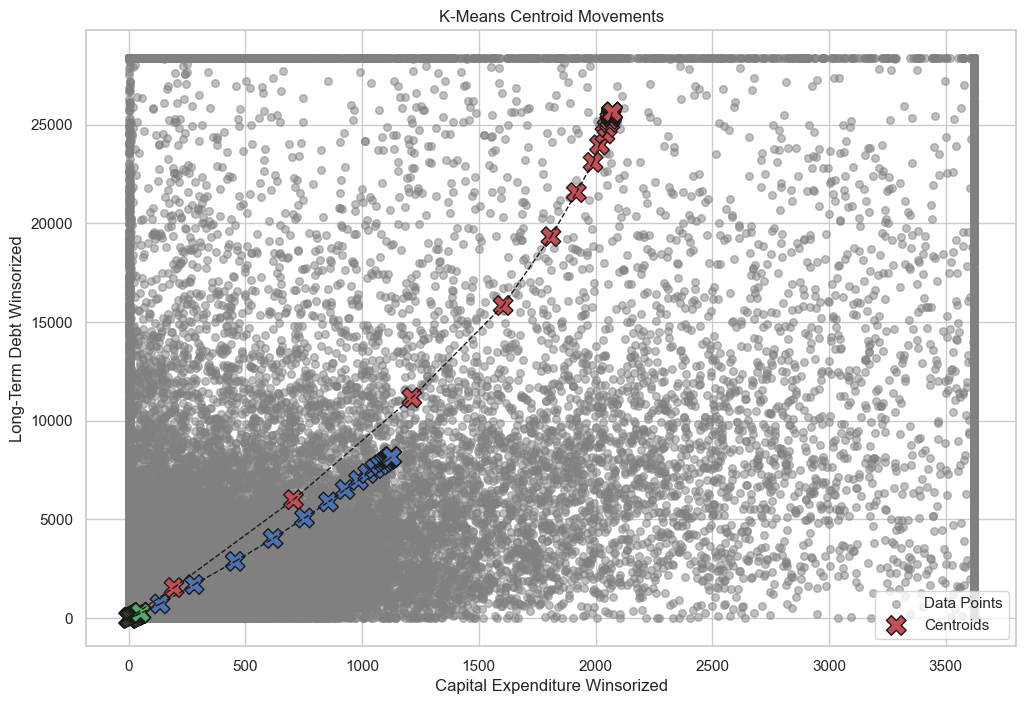

In [73]:
# Plot centroids history
plot_centroids_history(X_np, centroids_history, k)

In [75]:
# 4.2. Final Clustering Visualization
def plot_final_clusters(X, clusters, centroids):
    plt.figure(figsize=(12, 6))
    plt.title('Final K-Means Clustering')
    plt.xlabel('Capital Expenditure Winsorized')
    plt.ylabel('Long-Term Debt Winsorized')

    # Define color palette
    colors = ['r', 'g', 'b']

    # Plot each cluster
    for i in range(k):
        points = X[clusters == i]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=f'Cluster {i+1}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='yellow', marker='X', edgecolor='k', label='Centroids')

    plt.legend()
    plt.show()

C:\Users\andy_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


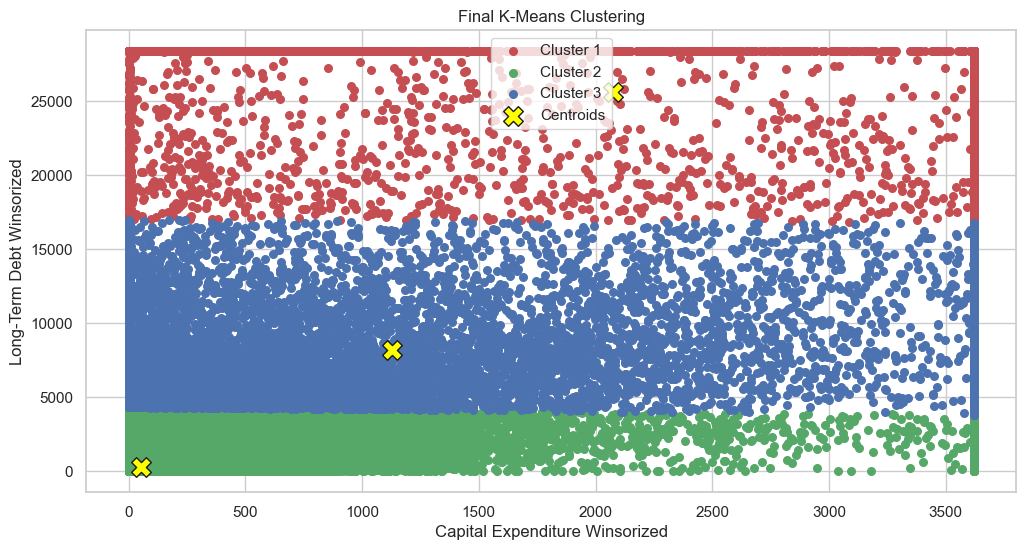

In [77]:
# Plot the final clusters
plot_final_clusters(X_np, clusters, centroids)

In [83]:
# 5. Creating the Animation of the K-Means Process
def create_k_means_animation(X, centroids_history, k, save=False, filename='k_means_animation.gif'):
    """
    Create and display an animation of the K-Means clustering process.

    Parameters:
    - X: Data points, numpy array of shape (n_samples, n_features)
    - centroids_history: List of centroids at each iteration
    - k: Number of clusters
    - save: Boolean indicating whether to save the animation as a GIF
    - filename: Filename for the saved GIF
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title('K-Means Clustering Animation')
    plt.xlabel('Capital Expenditure Winsorized')
    plt.ylabel('Long-Term Debt Winsorized')

    # Define colors for clusters
    colors = ['r', 'g', 'b']

    # Initialize scatter plot for data points
    scatter = ax.scatter(X[:, 0], X[:, 1], s=30, c='gray', alpha=0.5, label='Data Points')

    # Initialize centroids scatter plot
    centroids_scatter = ax.scatter([], [], s=200, c='yellow', marker='X', edgecolor='k', label='Centroids')

    # Initialize legend
    ax.legend()

    def update(frame):
        """
        Update function for animation.
        """
        ax.clear()
        plt.title('K-Means Clustering Animation')
        plt.xlabel('Capital Expenditure Winsorized')
        plt.ylabel('Long-Term Debt Winsorized')

        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], s=30, c='gray', alpha=0.5, label='Data Points')

        # Plot centroids up to the current frame
        current_centroids = centroids_history[frame]
        plt.scatter(current_centroids[:, 0], current_centroids[:, 1],
                    s=200,
                    c='yellow',
                    marker='X',
                    edgecolor='k',
                    label='Centroids')

        # Plot lines showing movement
        if frame > 0:
            previous_centroids = centroids_history[frame - 1]
            for i in range(k):
                plt.plot([previous_centroids[i, 0], current_centroids[i, 0]],
                         [previous_centroids[i, 1], current_centroids[i, 1]],
                         'k--', linewidth=1)

        plt.legend()

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(centroids_history), repeat=False, interval=1000)

    if save:
        # Save the animation as a GIF file
        anim.save(filename, writer='imagemagick')
        print(f"Animation saved as {filename}")
    else:
        # Display the animation
        plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\andy_\AppData\Local\Temp\ipykernel_26852\3420061759.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  anim.save(filename, writer='imagemagick')


Animation saved as lab4_k-means.gif


C:\Users\andy_\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\andy_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


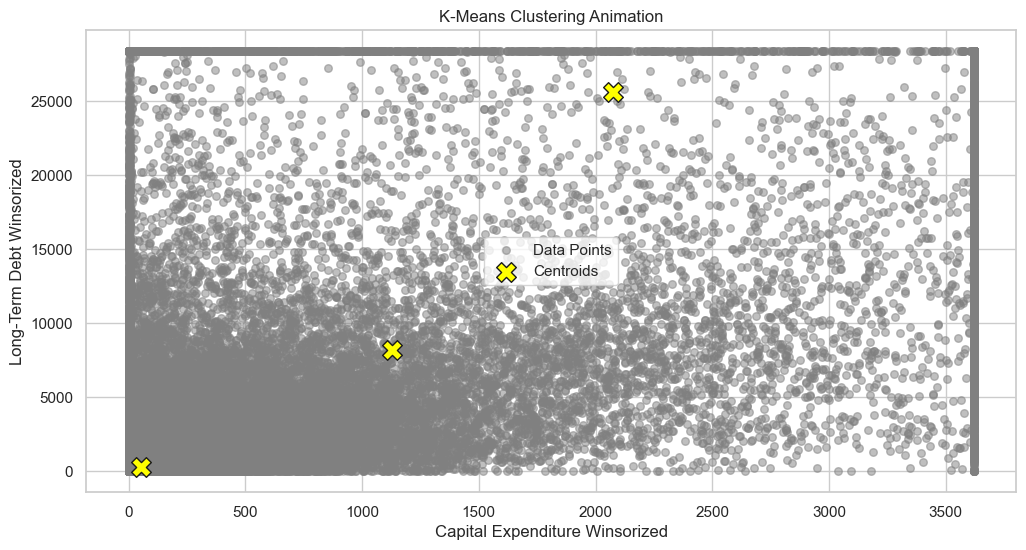

In [88]:
# Create and display the animation
create_k_means_animation(X_np, centroids_history, k, save=True, filename='lab4_k-means.gif')

# Optional: To save the animation as a GIF, set save=True and specify a filename
# create_k_means_animation(X_np, centroids_history, k, save=True, filename='k_means_animation.gif')